<a href="https://colab.research.google.com/github/sezaionurlu/Demand-Forecasting/blob/main/Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

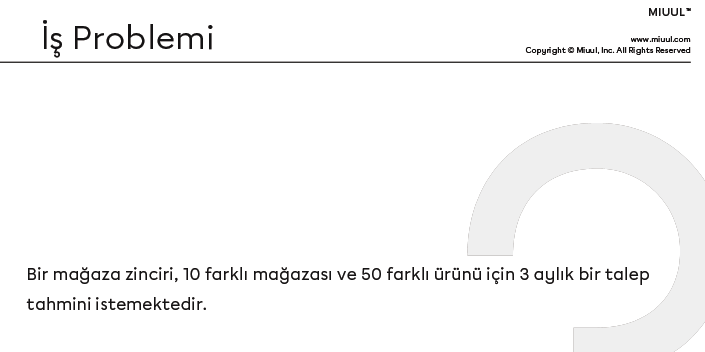

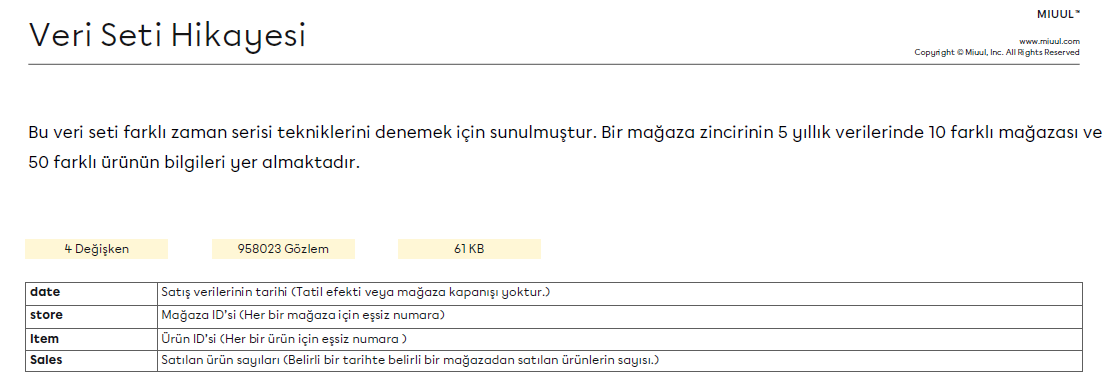

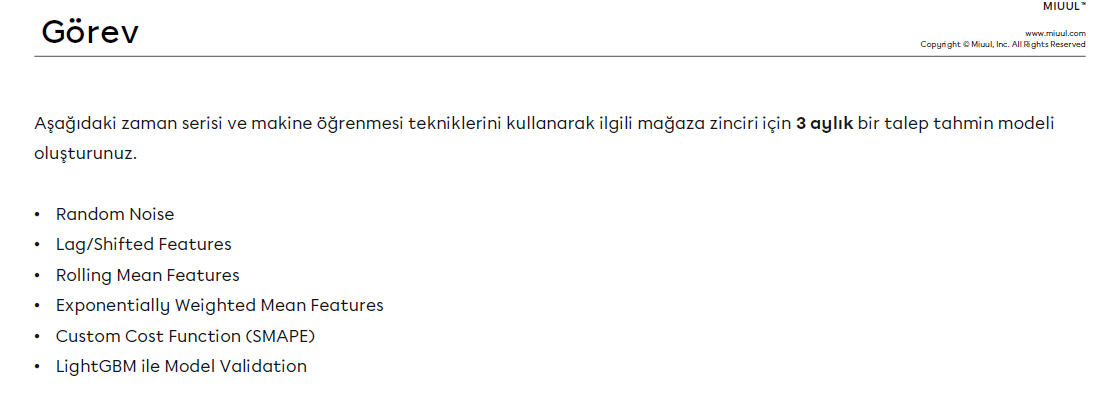

In [ ]:
!pip install lightgbm

import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Veri Bilimi/Ödevler/11/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/drive/MyDrive/Veri Bilimi/Ödevler/11/test.csv', parse_dates=['date'])

df = pd.concat([train, test], sort=False)

In [ ]:
df

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [ ]:
check_df(df)

##################### Shape #####################
(958023, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913023
dtype: int64
##################

In [ ]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [ ]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [ ]:
df = create_date_features(df)

In [ ]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [ ]:
########################
# Random Noise
########################

In [ ]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [ ]:
########################
# Lag/Shifted Features
########################

In [ ]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [ ]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 273, 364, 455, 546, 637, 728])

In [ ]:
check_df(df)

##################### Shape #####################
(958023, 27)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int64
day_of_month               int64
day_of_year                int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_273            float64
sales_lag_364            float64
sales_lag_455            float64
sales_lag_546            float64
sales_lag_637            float64
sales_lag_728            floa

In [ ]:
########################
# Rolling Mean Features
########################

In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [ ]:
df = roll_mean_features(df, [92 ,183, 274 ,365, 456, 547, 638, 729])

In [ ]:
########################
# Exponentially Weighted Mean Features
########################

In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [ ]:
########################
# One-Hot Encoding
########################

In [ ]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])


check_df(df)

##################### Shape #####################
(958023, 110)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 110, dtype: object
##################### Head #####################
         date  sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_273  sales_lag_364  sales_lag_455  sales_lag_546  sales_lag_637  sales_lag_728  sales_roll_mean_92  sales_roll_mean_183  sales_roll_mean_274  sales_roll_mean_365  sales_roll_mean_456  sales_roll_mean_547  sales_roll_mean_638  sales_roll_mean_72

In [ ]:
########################
# Converting sales to log(1+sales)
########################

In [ ]:
df['sales'] = np.log1p(df["sales"].values)

check_df(df)

##################### Shape #####################
(958023, 110)
##################### Types #####################
date            datetime64[ns]
sales                  float64
id                     float64
day_of_month             int64
day_of_year              int64
                     ...      
month_8                  uint8
month_9                  uint8
month_10                 uint8
month_11                 uint8
month_12                 uint8
Length: 110, dtype: object
##################### Head #####################
         date     sales  id  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_273  sales_lag_364  sales_lag_455  sales_lag_546  sales_lag_637  sales_lag_728  sales_roll_mean_92  sales_roll_mean_183  sales_roll_mean_274  sales_roll_mean_365  sales_roll_mean_456  sales_roll_mean_547  sales_roll_mean_638  sales_roll_mean

In [ ]:
#####################################################
# Model
#####################################################

In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [ ]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [ ]:
########################
# Time-Based Validation Sets
########################

In [ ]:
# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

In [ ]:
# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [ ]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [ ]:
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730523,), (730523, 106), (45000,), (45000, 106))

In [ ]:
########################
# LightGBM ile Zaman Serisi Modeli
########################

In [ ]:
# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

Training until validation scores don't improve for 200 rounds.
[100]	training's SMAPE: 17.3033	valid_1's SMAPE: 17.5228
[200]	training's SMAPE: 14.396	valid_1's SMAPE: 14.7789
[300]	training's SMAPE: 13.857	valid_1's SMAPE: 14.3012
[400]	training's SMAPE: 13.6479	valid_1's SMAPE: 14.1438
[500]	training's SMAPE: 13.5169	valid_1's SMAPE: 14.0486
[600]	training's SMAPE: 13.4216	valid_1's SMAPE: 13.9542
[700]	training's SMAPE: 13.3492	valid_1's SMAPE: 13.8771
[800]	training's SMAPE: 13.2915	valid_1's SMAPE: 13.8236
[900]	training's SMAPE: 13.2433	valid_1's SMAPE: 13.7766
[1000]	training's SMAPE: 13.2048	valid_1's SMAPE: 13.7372
Did not meet early stopping. Best iteration is:
[1000]	training's SMAPE: 13.2048	valid_1's SMAPE: 13.7372


13.737183127920625

In [ ]:
########################
# Değişken Önem Düzeyleri
########################

In [ ]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

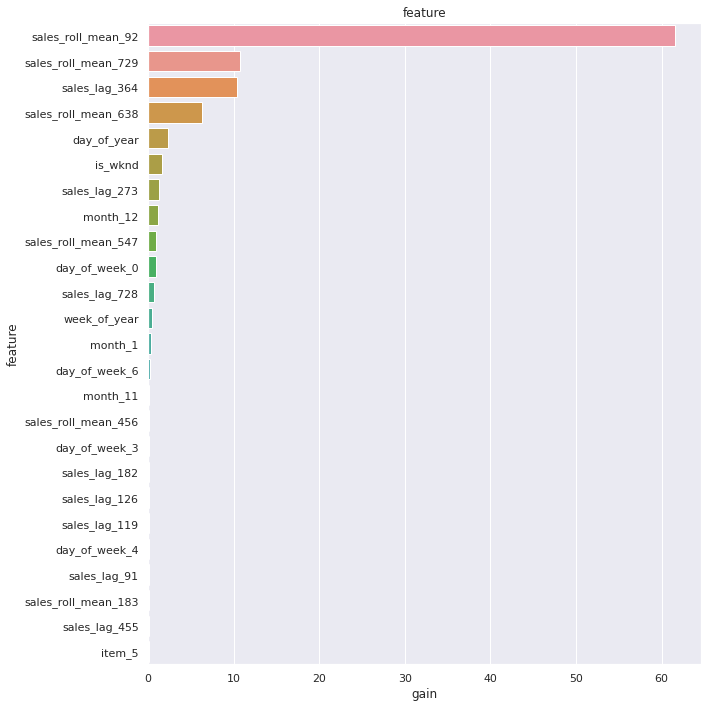

,feature,split,gain
19,sales_roll_mean_92,755,61.567819
26,sales_roll_mean_729,313,10.729090
14,sales_lag_364,1359,10.380516
25,sales_roll_mean_638,325,6.247949
1,day_of_year,1023,2.279207
...,...,...,...
47,item_11,0,0.000000
79,item_43,0,0.000000
55,item_19,0,0.000000
82,item_46,0,0.000000


In [ ]:
plot_lgb_importances(model, num=30, plot=True)

In [ ]:
########################
# Final Model
########################

In [ ]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

In [ ]:
test = df.loc[df.sales.isna()]
X_test = test[cols]

In [ ]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [ ]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:
test_preds

array([2.59978914, 2.76608122, 2.7683707 , ..., 3.85986328, 3.9423321 ,
       3.8945309 ])

In [ ]:
test.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_273,sales_lag_364,sales_lag_455,sales_lag_546,sales_lag_637,sales_lag_728,sales_roll_mean_92,sales_roll_mean_183,sales_roll_mean_274,sales_roll_mean_365,sales_roll_mean_456,sales_roll_mean_547,sales_roll_mean_638,sales_roll_mean_729,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,12.351579,15.905778,22.683949,17.772052,14.916589,15.282958,14.453139,14.986847,14.432071,20.700628,15.296858,19.307383,10.353413,20.849539,22.655051,25.703771,23.463542,24.563205,21.834279,23.162905,22.060249,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,18.582048,16.134357,19.793897,19.330347,25.471541,20.005039,22.520567,19.027864,7.146251,26.327555,31.210404,20.967778,13.276735,24.248254,26.187448,26.435210,21.943284,21.707337,21.636042,22.553013,19.216554,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,NaN,2.0,3,3,1,2018,0,0,0,14.154808,27.082719,18.438771,14.708790,24.374644,21.048702,25.871846,20.371542,14.994077,16.009100,23.227183,23.685663,17.611659,21.195351,26.456936,27.768220,23.457830,23.516427,26.338631,23.999491,19.642149,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2018-01-04,NaN,3.0,4,4,1,2018,0,0,0,19.236938,20.986729,19.047936,21.421951,28.293028,23.833724,31.733815,23.366719,15.059907,20.015087,32.748795,20.251117,12.518590,20.440058,23.292524,27.108455,23.049007,22.666953,20.554486,20.767848,22.520248,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2018-01-05,NaN,4.0,5,5,1,2018,1,0,0,19.301054,25.823074,28.044833,28.237819,28.411528,38.158659,29.554840,20.653992,27.873137,20.245154,33.801048,25.758287,9.910044,18.527728,20.708280,25.719846,24.238080,24.095923,20.817387,24.127465,24.152682,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds)

submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv("submission_demand.csv", index=False)

In [ ]:
submission_df

,id,sales
0,0,12.460899
1,1,14.896218
2,2,14.932654
3,3,14.827732
4,4,16.787536
...,...,...
44995,44995,45.582071
44996,44996,44.223976
44997,44997,46.458862
44998,44998,50.538655
